# 微信后台数据的检查指标的分析

In [1]:
import numpy as np
import pandas as pd
import os

# # 设置工作目录
# project_root = "D:/asl"
# os.chdir(project_root)
# 确认当前工作目录
print("Current working directory:", os.getcwd())


Current working directory: D:\asl


导入‘一些检查1.xlsx’中‘血生化’表

In [3]:
file_path = './dataset/一些检查1.xlsx'
sheet5 = '血生化'
df_bio_blood_test = pd.read_excel(file_path, sheet5)

导入'三个量表xlsx'中的‘ALSFRS-R评分量表'表

In [4]:
file_path = './dataset/三个量表.xlsx'
sheet2 = 'ALSFRS-R评分量表'
df_eval_AR = pd.read_excel(file_path, sheet2)

D:\asl\venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


导入‘发病情况.xlsx’中的‘治疗经历’表

In [5]:
file_path = './dataset/发病情况.xlsx'
sheet4 = '治疗经历'
df_drug = pd.read_excel(file_path, sheet4)

D:\asl\venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


合并df_drug 和 df_eval_AR

In [6]:
print(df_drug.shape)
print(df_eval_AR.shape)

# 根据患者编号合并两个 DataFrame  
merge_df_drug_AR = pd.merge(df_drug, df_eval_AR, on='患者编号', how='outer')  

# 确保 '总分' 是数值类型  
merge_df_drug_AR['总分'] = pd.to_numeric(merge_df_drug_AR['总分'])  
# 从 '总分' 列中删除包含 NaN 的行
merge_df_drug_AR = merge_df_drug_AR.dropna(subset=['总分'])


# 将 '评估日期' 列转换为 datetime 类型  
merge_df_drug_AR['评估日期'] = pd.to_datetime(merge_df_drug_AR['评估日期'])  
merge_df_drug_AR.dropna(subset=['评估日期'], inplace=True)  



# 查看合并后的 DataFrame  
print(merge_df_drug_AR.shape)

(4881, 1367)
(40354, 19)
(40260, 1385)


在merge_df_drug_AR表中数据清洗，并检索阿司匹林

In [48]:
key_word = '阿司匹林'

# 检查行中是否包含'阿司匹林'
def contains_aspirin(row):
    
    aspirin_dates = []  # 用于存储所有匹配到的日期
    bool_0 = 'N'
    for idx, value in enumerate(row.values):
        if isinstance(value, str) and key_word in value:
            bool_0 = 'Y'
            date_value = row.iloc[idx + 2]
            try: 
                date_value = pd.to_datetime(date_value, format='%Y-%m-%d')  # 尝试将值转换为日期格式
                if pd.notna(date_value):  # 再次检查转换后的日期值是否有效
                        aspirin_dates.append(date_value.date())
            except ValueError:  
                pass  
            # print(row.iloc[1], aspirin_dates)    
    
    return bool_0, aspirin_dates



# 添加Aspirin列，并用Y,N填充
merge_df_drug_AR['Aspirin'], merge_df_drug_AR['Aspirin_date'] = zip(*merge_df_drug_AR.apply(contains_aspirin, axis=1))  

print(merge_df_drug_AR.shape)

# 统计用过阿司匹林的记录
count = (merge_df_drug_AR['Aspirin'] == 'Y').sum()  
print("服用阿司匹林的患者提交的AR评分记录有: {}".format(count))

(40260, 1387)
服用阿司匹林的患者提交的AR评分记录有: 485


画出密度图

In [113]:
# # 绘制密度曲线  
# sns.displot(data=merge_df_drug_AR, x='总分', hue='Aspirin', kind="kde", fill=True)   

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def _kde_AR(df, species, kind, value):
    fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')  
    # 确保系统中有中文字体，并设置为 SimHei
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
    plt.rcParams['axes.unicode_minus'] = False    # 解决坐标轴负号显示问题

    # 绘制密度曲线  
    sns.kdeplot(data=df[df['Aspirin'] == 'Y'], x=value, label='Aspirin==Y', fill=True) 
    sns.kdeplot(data=df[df['Aspirin'] == 'N'], x=value, label='Aspirin==N', fill=True) 
    
    # 设置x轴范围，稍微扩展四分位距
    ar_values = df[value]
    ar_q1, ar_q3 = np.percentile(ar_values, [1, 99])  # 获取25%和75%分位数  
    plt.xlim((ar_q1 - (ar_q3 - ar_q1) * 0.1, ar_q3 + (ar_q3 - ar_q1) * 0.1))  

    # # 自动设置x轴范围，基于AR列的数据  
    # ar_values = df[value]
    # ar_min, ar_max = ar_values.min(), ar_values.max()  
    # # 稍微扩展范围以包含更多背景（可选）  
    # margin = (ar_max - ar_min) * 0.1  
    # plt.xlim((ar_min - margin, ar_max + margin))  
    
    # # 绘制直方图  
    # data_N = df[df['Aspirin'] == 'N']['AR_K']  # 提取Aspirin为'N'的行的'总分'列 
    # n, bins, patches = ax.hist(data_Y, bins=50, alpha=0.2, color='blue', edgecolor='blue', label='_nolegend_', density=True)  
    # n, bins, patches = ax.hist(data_N, bins=100, alpha=0.2, color='red', edgecolor='yellow', density=True)  

    # 根据 kind 参数设置标题和轴标签  
    if kind == 'K':  
        plt.title('AR斜率概率分布')  
        plt.xlabel('AR斜率')  
    else:  
        plt.title('AR总分概率分布')  
        plt.xlabel('AR总分')  
    plt.ylabel('Density')  
  
    # 显示网格  
    ax.grid(True)  
    # 显示图例  
    ax.legend() 
    # 显示图形  
    plt.show()





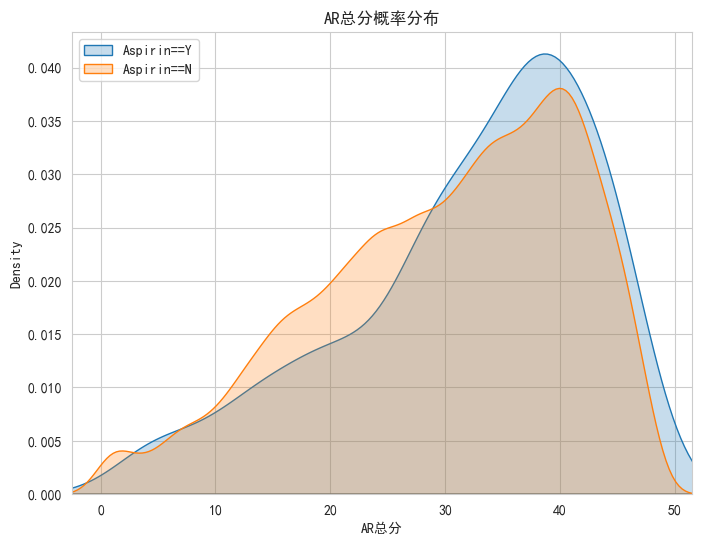

In [10]:
_kde_AR(merge_df_drug_AR, 'Aspirin', 'N', '总分')

In [11]:
print("服用过阿司匹林AR提交记录平均分:{}".format((merge_df_drug_AR[merge_df_drug_AR['Aspirin'] == 'Y']['总分']).mean()))
print("未服用过阿司匹林AR提交记录平均分:{}".format((merge_df_drug_AR[merge_df_drug_AR['Aspirin'] == 'N']['总分']).mean()))


服用过阿司匹林AR提交记录平均分:32.03092783505155
未服用过阿司匹林AR提交记录平均分:30.076555625392835


统计检验

In [12]:
# 根据Aspirin列的值分别取出AR列的值
X_Aspirin_N = merge_df_drug_AR[merge_df_drug_AR['Aspirin'] == 'N']['总分']
X_Aspirin_Y = merge_df_drug_AR[merge_df_drug_AR['Aspirin'] == 'Y']['总分']
# 检查并清理数据
X_Aspirin_N = X_Aspirin_N[~np.isnan(X_Aspirin_N)]  # 移除缺失值
X_Aspirin_Y = X_Aspirin_Y[~np.isnan(X_Aspirin_Y)]  # 移除缺失值
print(X_Aspirin_N.shape)
print(X_Aspirin_Y.shape)

(39775,)
(485,)


Kolmogorov-Smirnov检验用于检验数据是否符合正态分布。

In [13]:
from scipy.stats import kstest

def S_K_NORM(X_1, X_2):
    # 对X_Aspirin_N进行Kolmogorov-Smirnov正态性检验
    statistic1, p_value1 = kstest(X_1, 'norm', args=(np.mean(X_1), np.std(X_1)))
    print(f"X_Aspirin_N的Kolmogorov-Smirnov统计量: {statistic1}, p值: {p_value1}")

    # 对X_Aspirin_Y进行Kolmogorov-Smirnov正态性检验
    statistic2, p_value2 = kstest(X_2, 'norm', args=(np.mean(X_2), np.std(X_2)))
    print(f"X_Aspirin_Y的Kolmogorov-Smirnov统计量: {statistic2}, p值: {p_value2}")

    # 判断是否正态分布
    alpha = 0.05
    if p_value1 > alpha:
        print("X_Aspirin_N样本数据可能来自正态分布")
    else:
        print("X_Aspirin_N样本数据不来自正态分布")

    if p_value2 > alpha:
        print("X_Aspirin_Y样本数据可能来自正态分布")
    else:
        print("X_Aspirin_Y样本数据不来自正态分布")

S_K_NORM(X_Aspirin_Y, X_Aspirin_N)

X_Aspirin_N的Kolmogorov-Smirnov统计量: 0.1166301904978011, p值: 3.3266987193272647e-06
X_Aspirin_Y的Kolmogorov-Smirnov统计量: 0.08722016437988267, p值: 1.0259920472586262e-263
X_Aspirin_N样本数据不来自正态分布
X_Aspirin_Y样本数据不来自正态分布


Kolmogorov-Smirnov检验用于检验数据是否来自同一种分布

In [14]:
from scipy.stats import ks_2samp

def S_K_SAMP(X1, X2): 
    # Kolmogorov-Smirnov检验
    statistic, p_value = ks_2samp(X_Aspirin_Y, X_Aspirin_N)
    print(f"Kolmogorov-Smirnov 统计量: {statistic}, p值: {p_value}")

    # 判断是否来自同一分布
    alpha = 0.05
    if p_value > alpha:
        print("样本可能来自同一分布")
    else:
        print("样本可能不来自同一分布")

S_K_SAMP(X_Aspirin_N,X_Aspirin_Y)

Kolmogorov-Smirnov 统计量: 0.09972927614740129, p值: 0.00013389448263293624
样本可能不来自同一分布


假设两个样本是正态的

使用F检验检查他们的方差是否相等

In [15]:
from scipy.stats import f

def F_p(X1,X2):
    # 计算样本方差
    var1 = np.var(X1, ddof=1)
    var2 = np.var(X2, ddof=1)

    # 计算F统计量
    F = var1 / var2

    # 计算自由度
    df1 = len(X1) - 1
    df2 = len(X2) - 1

    # 计算p值
    p_value = 2 * min(f.cdf(F, df1, df2), 1 - f.cdf(F, df1, df2))

    print(f"F 统计量: {F}, p值: {p_value}")

    # 判断方差是否相等
    alpha = 0.05
    if p_value > alpha:
        print("样本方差没有显著性差异，可以认为方差相等")
    else:
        print("样本方差存在显著性差异，不能认为方差相等")
    
F_p(X_Aspirin_Y,X_Aspirin_N)


F 统计量: 0.9573664191308147, p值: 0.5170989461526382
样本方差没有显著性差异，可以认为方差相等


由于方差相等，使用t检验检验均值

In [16]:
from scipy.stats import ttest_ind, levene, bartlett
def t_test(X1,X2):
    # 进行t检验
    statistic, p_value = ttest_ind(X1, X2)
    print(f"t 检验统计量: {statistic}, p值: {p_value}")

    # 判断是否拒绝原假设
    alpha = 0.05
    if p_value > alpha:
        print("无法拒绝原假设，两个样本的均值可能相等")
    else:
        print("拒绝原假设，两个样本的均值显著不同")
        
t_test(X_Aspirin_Y, X_Aspirin_N)

t 检验统计量: 3.8452273672569395, p值: 0.00012062595813731452
拒绝原假设，两个样本的均值显著不同


# 统计ar斜率和阿司匹林关系

转换数据类型

In [23]:
# # 找出重复的患者编号  
# duplicate_ids = merge_df_drug_AR['患者编号'].duplicated(keep=False)  
# duplicate_patients = merge_df_drug_AR[duplicate_ids]  
# print(duplicate_patients.shape)
# patient_id_counts = merge_df_drug_AR['患者编号'].value_counts()  
# print(patient_id_counts)

# #转换评估时间数据类型
# merge_df_drug_AR.dropna(subset=['评估日期'], inplace=True)  
# merge_df_drug_AR['评估日期'] = pd.to_datetime(merge_df_drug_AR['评估日期'])


分组聚合

In [18]:
# 根据患者编号使用agg聚合
merge_df_drug_AR.sort_values(by=['患者编号', '评估日期'], inplace=True)  
grouped = merge_df_drug_AR.groupby('患者编号').agg(  
    最早时间=('评估日期', 'min'),  
    最早总分=('总分', 'first'),  
    最晚时间=('评估日期', 'max'),  
    最晚总分=('总分', 'last'),   
    Aspirin=('Aspirin', 'first')   
).reset_index()  # 确保患者编号列存在


In [19]:
#AR斜率计算函数
def AR_k(df):
    # 计算每个患者的治疗天数差  
    df['天数差'] = ((df['最晚时间'] - df['最早时间'])).dt.days 
    # 计算月份差
    df['月份差'] = (df['最晚时间'].dt.to_period('M') - df['最早时间'].dt.to_period('M')).apply(lambda x: x.n)

 
    # 计算每个患者的总分变化  
    df['总分差'] = df['最晚总分'] - df['最早总分']  
    # 计算AR斜率 
    df['AR_K_day'] = df['总分差'] / df['天数差']  
    df['AR_K_Mon'] = df['总分差'] / df['月份差']  

In [20]:
AR_k(grouped)
# 删除AR_Slope列中包含NaN的行  
grouped = grouped.dropna(subset=['AR_K_Mon'])
print(grouped.shape)

(4341, 11)


In [21]:
# 筛选出包含inf或-inf的行  
inf_or_neg_inf_rows = grouped[(grouped == np.inf).any(axis=1) | (grouped == -np.inf).any(axis=1)]  

print(inf_or_neg_inf_rows.shape)
# 删除包含inf或-inf的行  
grouped = grouped[(grouped['AR_K_Mon'] != np.inf) & (grouped['AR_K_Mon'] != -np.inf)]  

(66, 11)


导出文件

In [22]:
grouped.to_csv('D:/asl/id_AR_K.csv', index=False, encoding='utf-8-sig')

In [23]:
#提取数据
AR_K_Aspirin_Y = grouped[grouped['Aspirin']=='Y']['AR_K_Mon']
AR_K_Aspirin_N = grouped[grouped['Aspirin']=='N']['AR_K_Mon']
print(AR_K_Aspirin_Y.shape)

(54,)


绘制密度曲线

In [24]:
#需要删除一些离群值，否则kde拟合不出来
df_group_draw_0 = grouped
print(df_group_draw_0.shape)
df_group_draw_1 = df_group_draw_0[(df_group_draw_0['AR_K_Mon'] < 7)&(df_group_draw_0['AR_K_Mon'] > -7)]
print(df_group_draw_1[df_group_draw_1['Aspirin']=='Y'].shape)


(4275, 11)
(52, 11)


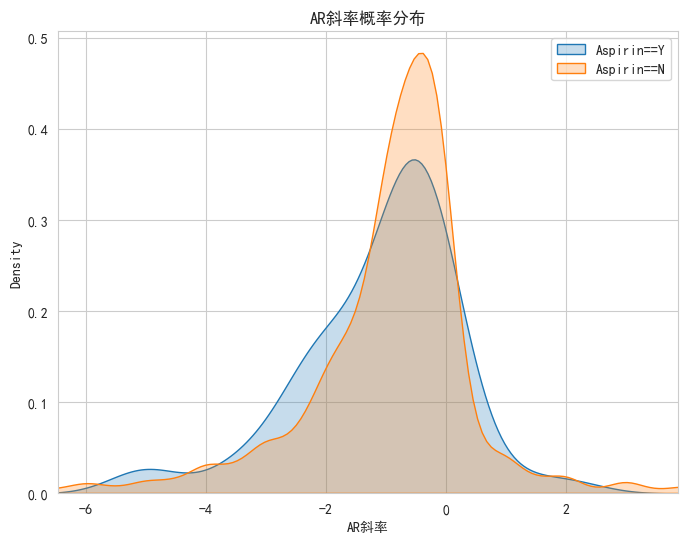

In [27]:
#画kde
_kde_AR(df_group_draw_1, 'Aspirin', 'K', 'AR_K_Mon')

这个kde图可能拟合的太暴力了，可能直方图结果更明显一点，以检验结果为准吧

绘制直方图

(array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 1., 2., 1.,
        6., 2., 2., 1., 4., 9., 5., 6., 7., 0., 0., 0., 1., 0., 0., 1.]),
 array([-11.  , -10.74, -10.48, -10.22,  -9.96,  -9.7 ,  -9.44,  -9.18,
         -8.92,  -8.66,  -8.4 ,  -8.14,  -7.88,  -7.62,  -7.36,  -7.1 ,
         -6.84,  -6.58,  -6.32,  -6.06,  -5.8 ,  -5.54,  -5.28,  -5.02,
         -4.76,  -4.5 ,  -4.24,  -3.98,  -3.72,  -3.46,  -3.2 ,  -2.94,
         -2.68,  -2.42,  -2.16,  -1.9 ,  -1.64,  -1.38,  -1.12,  -0.86,
         -0.6 ,  -0.34,  -0.08,   0.18,   0.44,   0.7 ,   0.96,   1.22,
          1.48,   1.74,   2.  ]),
 <BarContainer object of 50 artists>)

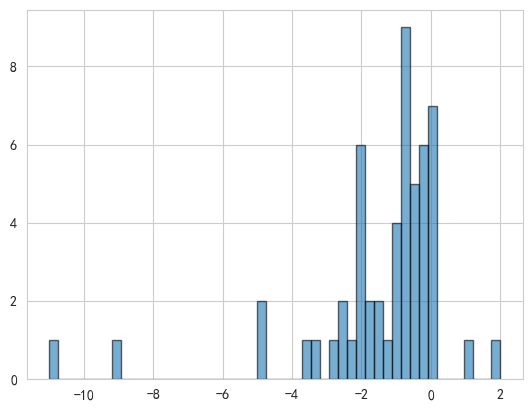

In [30]:
# plt.hist(AR_K_Aspirin_N_DE, bins=50, edgecolor='black', alpha=0.6, label='Aspirin N')
plt.hist(AR_K_Aspirin_Y, bins=50, edgecolor='black', alpha=0.6, label='Aspirin Y')


检验

In [31]:


print('未服用阿司匹林的患者的平均AR月斜率：{}'.format(AR_K_Aspirin_N.mean()))
print('服用阿司匹林的患者的平均AR月斜率：{}'.format(AR_K_Aspirin_Y.mean()))

未服用阿司匹林的患者的平均AR月斜率：-1.0124755108863008
服用阿司匹林的患者的平均AR月斜率：-1.4441663270149045


服用阿司匹林的病人发展反而更快，奇了个大怪

S-K检验

In [39]:
S_K_NORM(AR_K_Aspirin_N,AR_K_Aspirin_Y)

X_Aspirin_N的Kolmogorov-Smirnov统计量: 0.2000611727903755, p值: 1.4933291750289568e-148
X_Aspirin_Y的Kolmogorov-Smirnov统计量: 0.19940871943580918, p值: 0.023368423644392622
X_Aspirin_N样本数据不来自正态分布
X_Aspirin_Y样本数据不来自正态分布


In [40]:
S_K_SAMP(AR_K_Aspirin_Y,AR_K_Aspirin_N)

Kolmogorov-Smirnov 统计量: 0.09972927614740129, p值: 0.00013389448263293624
样本可能不来自同一分布


假设正态

F检验方差

In [41]:
F_p(AR_K_Aspirin_N,AR_K_Aspirin_Y)

F 统计量: 0.9642329571529511, p值: 0.8019468272965505
样本方差没有显著性差异，可以认为方差相等


t-检验

In [42]:
t_test(AR_K_Aspirin_N,AR_K_Aspirin_Y)

t 检验统计量: 1.5058063211391535, p值: 0.13219081550801112
无法拒绝原假设，两个样本的均值可能相等


# 根据阿司匹林用药时间筛选病人

In [60]:
#选出Aspirin=Y的行
df_Asprin_Y = merge_df_drug_AR[merge_df_drug_AR['Aspirin']=='Y']
sim = ['患者编号', 'Aspirin_date', '评估日期', '总分','Aspirin']
df_Asprin_Y_sim = df_Asprin_Y[sim]
print(df_Asprin_Y_sim.shape)

(485, 5)


筛选出在用过Asiplin后仍有AR评分的用户

主要做一下，病人在服用阿司匹林前后的的AR评分变化情况

In [65]:
# 按患者编号分组，并转换为字典
merged_df_AR_after_Aspirin_groupbyed = merge_df_drug_AR.groupby("患者编号").apply(
    lambda x: pd.Series({
        "评估日期_总分": {
            date: {"总分": AR}
            for date, AR in zip(x["评估日期"], x["总分"])
        },
        "Aspirin_date_x": x["Aspirin_date_x"].iloc[0]  # 假设每个患者的Aspirin_date是相同的
    })  
).reset_index()


print(merged_df_AR_after_Aspirin_groupbyed)


            患者编号                                            评估日期_总分  \
0   202110120013  {2021-10-15 00:00:00: {'总分': 43.0}, 2021-11-11...   
1   202111110002  {2021-11-11 00:00:00: {'总分': 44.0}, 2022-01-07...   
2   202111140011                {2021-11-17 00:00:00: {'总分': 40.0}}   
3   202112080006  {2021-12-15 00:00:00: {'总分': 15.0}, 2022-06-22...   
4   202201110008                {2022-01-11 00:00:00: {'总分': 45.0}}   
5   202202080007                {2022-02-08 00:00:00: {'总分': 43.0}}   
6   202204130003  {2022-04-13 00:00:00: {'总分': 41.0}, 2022-05-08...   
7   202302140002                {2023-02-14 00:00:00: {'总分': 32.0}}   
8   202304040012  {2023-04-18 00:00:00: {'总分': 39.0}, 2024-03-13...   
9   202304250001  {2023-04-25 00:00:00: {'总分': 45.0}, 2023-05-25...   
10  202306040006                {2023-06-07 00:00:00: {'总分': 39.0}}   

              Aspirin_date_x  
0               [2021-09-26]  
1               [2021-11-03]  
2               [2021-11-01]  
3               [2021-1

C:\Users\徐文韬\AppData\Local\Temp\ipykernel_10252\2943422486.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df_AR_after_Aspirin_groupbyed = merged_df_AR_after_Aspirin.groupby("患者编号").apply(


C:\Users\徐文韬\AppData\Local\Temp\ipykernel_10252\994936861.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_patients_to_plot)


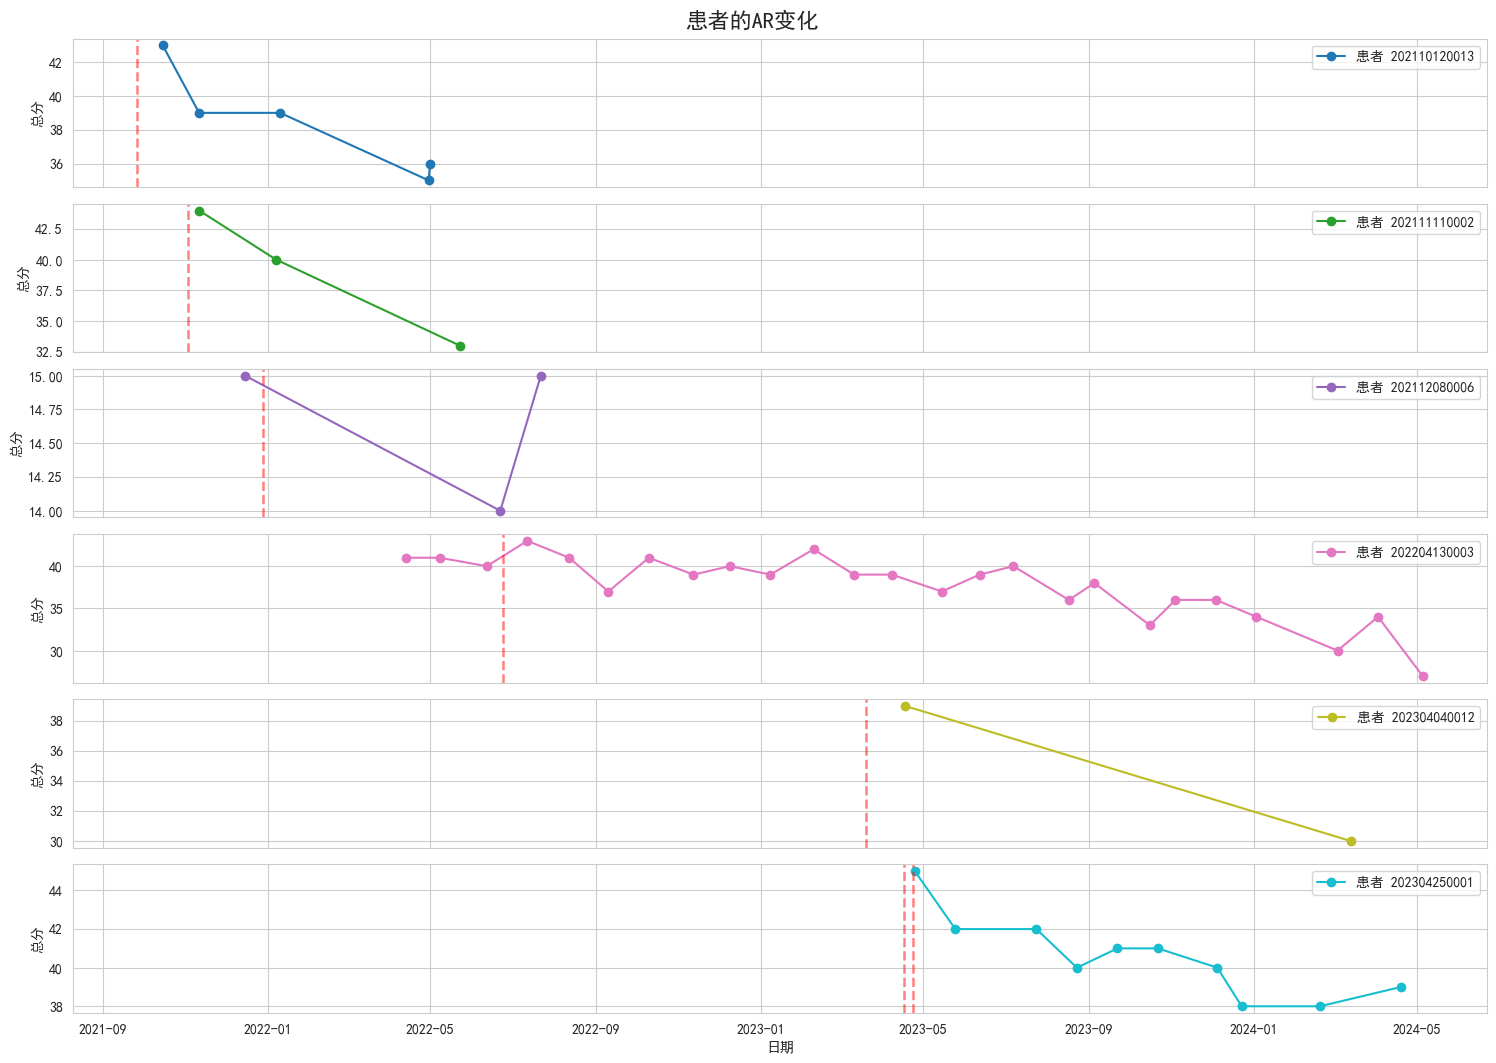

In [99]:
# 过滤掉评估日期数量只有一个的患者
filtered_df = merged_df_AR_after_Aspirin_groupbyed[
    merged_df_AR_after_Aspirin_groupbyed["评估日期_总分"].apply(len) > 1
]

# 计算需要绘制的子图数量
num_patients_to_plot = len(filtered_df)

# 创建图形
fig, axs = plt.subplots(num_patients_to_plot, 1, figsize=(15, num_patients_to_plot * 1.8), sharex=True)

# 默认颜色循环
colors = plt.cm.get_cmap('tab10', num_patients_to_plot)

# 绘制每个患者的图形
for ax, (index, row), color in zip(axs, filtered_df.iterrows(), colors(range(num_patients_to_plot))):
    patient_id = row["患者编号"]
    dates_scores = row["评估日期_总分"]
    aspirin_dates = row["Aspirin_date_x"]
    
    # 评估日期和总分
    dates = list(dates_scores.keys())
    scores = [dates_scores[date]["总分"] for date in dates]
    
    # 画折线图
    ax.plot(dates, scores, marker='o', label=f'患者 {patient_id}', color=color)
    
    # 画 Aspirin_date 的竖线
    for aspirin_date in aspirin_dates:
        ax.axvline(aspirin_date, color='red', alpha=0.5, linestyle='--', linewidth=1.8)
    
    # 设置图例
    ax.legend()
    ax.set_ylabel('总分')
    
# 设置 x 轴标签
axs[-1].set_xlabel('日期')

# 调整 x 轴标签旋转角度
plt.xticks(rotation=0)

# 设置总体标题
fig.suptitle('患者的AR变化', fontsize=16)
plt.tight_layout()  

plt.show()